In [ ]:
!pip install -q qiskit qiskit-nature qiskit-aer pyscf qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import SLSQP, SPSA
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
import pyscf


#added for excited stuff
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper

ModuleNotFoundError: No module named 'qiskit_nature'

#Noiseless stuff

In [ ]:
from qiskit_aer.primitives import Estimator

def get_qubit_op(dist):
    molecule = MoleculeInfo(
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    properties = driver.run()

    problem = FreezeCoreTransformer(
        freeze_core=False
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 1.5, 0.05)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
plt.plot(distances, exact_energies, label="Tiksli energija")
plt.plot(distances, vqe_energies, label="VQE energija")
plt.xlabel("Atstumas tarp atomų Angstremais")
plt.ylabel("Energija")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

#Excited stuff

In [ ]:
from qiskit.primitives import Estimator

def get_problem(dist):

    molecule = MoleculeInfo(
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    properties = driver.run()

    problem = FreezeCoreTransformer(
        freeze_core=False
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper()
    return num_particles, num_spatial_orbitals, problem, mapper

In [ ]:

vqe_energies = []
optimizer = SLSQP()
noiseless_estimator = Estimator()

def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values["ParticleNumber"][0], 2.0) and np.isclose(
        aux_values["Magnetization"][0], 0.0
    )


exact_energies=[]

qeomvqe_energies=[]

distances = np.arange(0.1, 1.5, 0.05)

for dist in distances:

    (num_particles, num_spatial_orbitals, problem, mapper) = get_problem(dist)


    numpy_solver = NumPyEigensolver(k=4, filter_criterion=filter_criterion)

    numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
    numpy_results = numpy_excited_states_solver.solve(problem)


    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0.0] * var_form.num_parameters,
    )

    gse = GroundStateEigensolver(mapper, vqe)

    qeom_excited_states_solver = QEOM(gse, noiseless_estimator, "sd", EvaluationRule.ALL)

    qeom_results = qeom_excited_states_solver.solve(problem)

    # print(
    #     f"Interatomic Distance: {np.round(dist, 2)}",
    #     f"VQE Result: {vqe_result:.5f}",
    #     f"Exact Energy: {exact_energies[-1]:.5f}",
    # )

    # print(
    #     f"Interatomic Distance: {np.round(dist, 2)}")
    # print(numpy_results.total_energies)
    # print("\n\n")
    # # print(qeom_results)
    # print(qeom_results.total_energies)
    # print("-------------------------------------")

    exact_energies.append(numpy_results.total_energies)
    qeomvqe_energies.append(qeom_results.total_energies)

print("All energies have been calculated")

All energies have been calculated


[array([2.70996077, 4.58661318, 4.8989537 , 6.83107275]), array([0.9872194 , 2.77748094, 3.09134194, 4.93664772]), array([0.15748213, 1.83993163, 2.15587705, 3.892822  ]), array([-0.3122699 ,  1.25008782,  1.56864099,  3.18485267]), array([-0.60180371,  0.83607559,  1.15771263,  2.64874383]), array([-0.78926939,  0.52559625,  0.8507427 ,  2.21802288]), array([-0.9141497 ,  0.2829341 ,  0.61196495,  1.86070463]), array([-0.9984156 ,  0.08820662,  0.42144942,  1.55894845]), array([-1.05515979, -0.07074011,  0.26700034,  1.30148575]), array([-1.09262991, -0.20191839,  0.14057064,  1.08048357]), array([-1.11628601, -0.31096009,  0.0365012 ,  0.89008467]), array([-1.12990478, -0.402052  , -0.0494151 ,  0.72564537]), array([-1.13618945, -0.47845306, -0.1204519 ,  0.5833141 ]), array([-1.13711707, -0.5427821 , -0.17923903,  0.45980452]), array([-1.13414767, -0.5971778 , -0.22792423,  0.35228457]), array([-1.12836188, -0.64339155, -0.26826785,  0.25832675]), array([-1.12056028, -0.68284939, -0

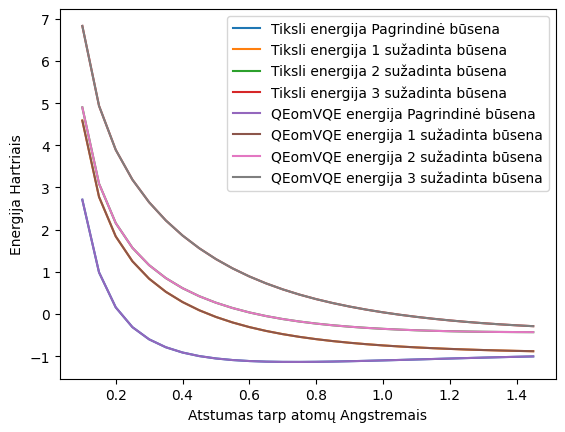

In [ ]:
print(exact_energies)

exact_transposed= np.transpose(exact_energies)

qeomvqe_transposed= np.transpose(qeomvqe_energies)





plt.plot(distances, exact_transposed[0], label="Tiksli energija Pagrindinė būsena")
plt.plot(distances, exact_transposed[1], label="Tiksli energija 1 sužadinta būsena")
plt.plot(distances, exact_transposed[2], label="Tiksli energija 2 sužadinta būsena")
plt.plot(distances, exact_transposed[3], label="Tiksli energija 3 sužadinta būsena")

plt.plot(distances, qeomvqe_transposed[0], label="QEomVQE energija Pagrindinė būsena")
plt.plot(distances, qeomvqe_transposed[1], label="QEomVQE energija 1 sužadinta būsena")
plt.plot(distances, qeomvqe_transposed[2], label="QEomVQE energija 2 sužadinta būsena")
plt.plot(distances, qeomvqe_transposed[3], label="QEomVQE energija 3 sužadinta būsena")
plt.xlabel("Atstumas tarp atomų Angstremais")
plt.ylabel("Energija Hartriais")
plt.legend()
plt.show()

#Noisy stuff

In [ ]:
from qiskit_aer.primitives import Estimator

molecule = MoleculeInfo(
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
problem = driver.run()

second_q_ops = problem.second_q_ops()
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)

hamiltonian = second_q_ops[0]

# Do two qubit reduction
qubit_op = mapper.map(hamiltonian)

In [ ]:

from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)



In [ ]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


exact_energies = []
vqe_energies = []
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.05010962]
